# Medical Image Classification with MONAI

In [6]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [7]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

In [8]:
class _3D_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        return {'images': data, 'label': label}

In [23]:
train_dataset_ = _3D_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = _3D_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = _3D_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Training cycle

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=3, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [27]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4443
2/30, train_loss: 2.1997
3/30, train_loss: 2.1206
4/30, train_loss: 2.2416
5/30, train_loss: 2.2784
6/30, train_loss: 1.9537
7/30, train_loss: 2.0057
8/30, train_loss: 1.8493
9/30, train_loss: 1.7903
10/30, train_loss: 1.9345
11/30, train_loss: 2.1499
12/30, train_loss: 1.8487
13/30, train_loss: 1.6527
14/30, train_loss: 1.7698
15/30, train_loss: 1.5879
16/30, train_loss: 1.3832
17/30, train_loss: 1.7193
18/30, train_loss: 1.2333
19/30, train_loss: 1.5106
20/30, train_loss: 1.5963
21/30, train_loss: 1.4083
22/30, train_loss: 1.3370
23/30, train_loss: 1.2916
24/30, train_loss: 1.2140
25/30, train_loss: 1.5808
26/30, train_loss: 1.4157
27/30, train_loss: 1.2482
28/30, train_loss: 1.1371
29/30, train_loss: 1.1910
30/30, train_loss: 1.3999
31/30, train_loss: 1.1111
epoch 1 average loss: 1.6647
1
saved new best metric model
current epoch: 1 current AUC: 0.5230 current accuracy: 0.0932 best AUC: 0.5230 at epoch: 1
----------
epoch 2/100
1/30, t

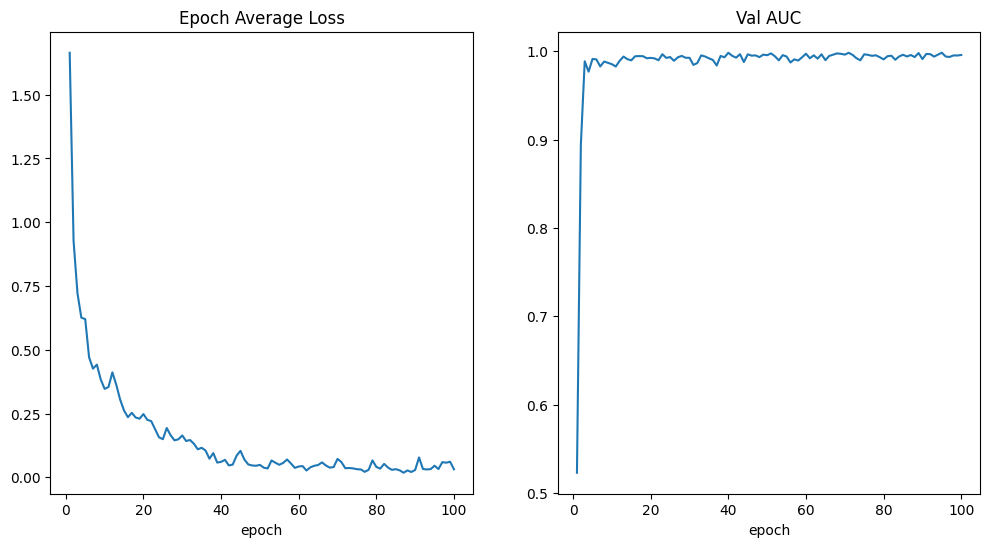

In [28]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [29]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [30]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6250    0.6618    0.6429        68
           2     0.7069    0.5942    0.6457        69
           3     0.5517    0.4923    0.5203        65
           4     0.5200    0.6000    0.5571        65
           5     0.9000    0.9545    0.9265        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.2857    0.4444        21
           8     0.5833    1.0000    0.7368        21
           9     0.9130    0.9130    0.9130        69
          10     0.9437    0.9710    0.9571        69

    accuracy                         0.7721       610
   macro avg     0.7936    0.7605    0.7527       610
weighted avg     0.7831    0.7721    0.7676       610



## Pretrained model

## Training cycle

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True, spatial_dims=3, n_input_channels=1, 
                 feed_forward=False, shortcut_type='A', bias_downsample=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [32]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
model.avgpool = nn.Sequential(
    model.avgpool,
    nn.Flatten(),
    nn.Linear(512, n_classes)
).to(device)

In [34]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.9049
2/30, train_loss: 2.5704
3/30, train_loss: 2.6674
4/30, train_loss: 2.4559
5/30, train_loss: 2.5869
6/30, train_loss: 2.5787
7/30, train_loss: 2.4022
8/30, train_loss: 2.5380
9/30, train_loss: 2.4131
10/30, train_loss: 2.3746
11/30, train_loss: 2.3702
12/30, train_loss: 2.4028
13/30, train_loss: 2.3308
14/30, train_loss: 2.2903
15/30, train_loss: 2.2887
16/30, train_loss: 2.2014
17/30, train_loss: 2.1434
18/30, train_loss: 2.1809
19/30, train_loss: 2.0395
20/30, train_loss: 2.0248
21/30, train_loss: 2.1840
22/30, train_loss: 2.0324
23/30, train_loss: 1.9794
24/30, train_loss: 1.8705
25/30, train_loss: 2.0010
26/30, train_loss: 1.9367
27/30, train_loss: 1.8256
28/30, train_loss: 1.7901
29/30, train_loss: 1.7818
30/30, train_loss: 1.9165
31/30, train_loss: 2.0947
epoch 1 average loss: 2.2315
1
saved new best metric model
current epoch: 1 current AUC: 0.5580 current accuracy: 0.1304 best AUC: 0.5580 at epoch: 1
----------
epoch 2/100
1/30, t

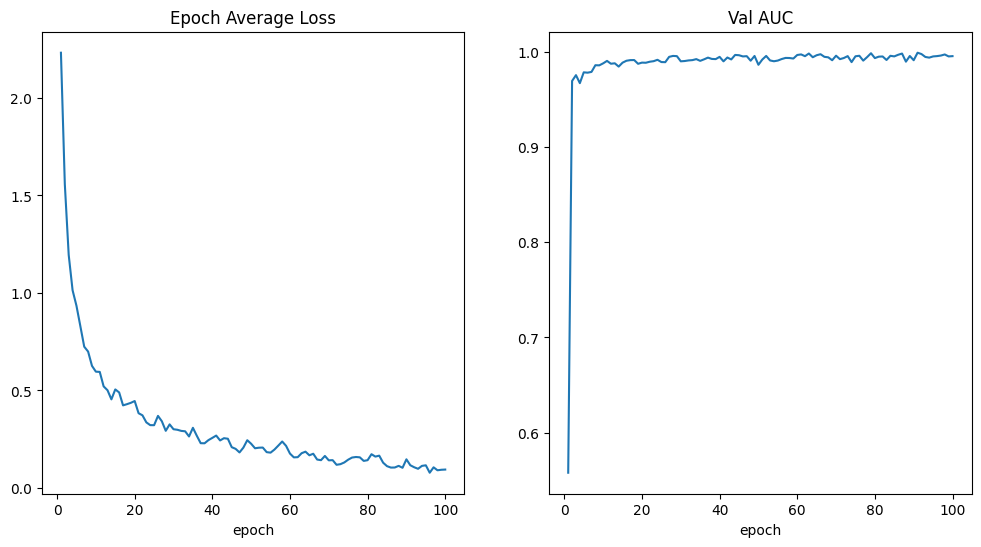

In [35]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [36]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'].to(device),
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example) < 10:
            example.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [37]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.6053    0.6765    0.6389        68
           2     0.6364    0.6087    0.6222        69
           3     0.6176    0.3231    0.4242        65
           4     0.5368    0.7846    0.6375        65
           5     1.0000    0.8939    0.9440        66
           6     1.0000    0.9643    0.9818        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9275    0.9275    0.9275        69
          10     0.9296    0.9565    0.9429        69

    accuracy                         0.7984       610
   macro avg     0.8386    0.8305    0.8277       610
weighted avg     0.8054    0.7984    0.7939       610

